### Mercari Price 
The files consist of a list of product listings. These files are tab-delimited.

Fields:
- train_id or test_id - the id of the listing

- name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid  leakage. These removed prices are represented as [rm]

- item_condition_id - the condition of the items provided by the seller

- category_name - category of the listing

- brand_name

- price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.

- shipping - 1 if shipping fee is paid by seller and 0 by buyer

- item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

In [1]:
import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize
import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.backend as K


from tqdm._tqdm_notebook import tqdm_notebook

import os
import itertools

import matplotlib.pyplot as plt
import itertools
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import Dense, Input, Embedding, Concatenate, Flatten, Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from nltk.corpus import stopwords
import string

import pickle

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  


In [2]:
nltk.download('stopwords')
nltk.download('punkt')


stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
tqdm_notebook.pandas()

In [4]:
#! pip install pydot graphviz

### Dataset download

In [17]:
# check if in colab
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    print("Running in colab")
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    colab_root = '/content/drive'
    root_dir = "/content/gdrive/My Drive/"
    base_dir = root_dir + 'project-mercari-price/'
    if not os.path.isdir(base_dir):
        os.mkdir(base_dir)
else:
    root_dir= os.getcwd()
    base_dir = root_dir
    
os.chdir(base_dir)

Running in colab
Mounted at /content/gdrive


In [18]:
dataset_downloaded_path = os.path.join(base_dir, "dataset_downloaded.ignore")
dataset_downloaded = os.path.isfile(dataset_downloaded_path)
dataset_downloaded

True

In [19]:
if not dataset_downloaded:
  # install kaggle to download dataset
  ! pip install kaggle python-dotenv

In [20]:
# set to True if you want to save kaggle credentials into a .env file
persist_credentials = False

if not dataset_downloaded:
  # create .env file containing KAGGLE_USER and KAGGLE_KEY
    kaggle_env = os.path.join(base_dir, '.env')
    if not os.path.isfile(kaggle_env):
        with open(kaggle_env, 'w') as envfile:
            kaggle_user = input("Insert kaggle username")
            kaggle_key = input("Insert kaggle key; generate one from kaggle account")
        if persist_credentials:
            envfile.write(f"""
            KAGGLE_USERNAME={kaggle_user}
            KAGGLE_KEY={kaggle_key}
            """)

        # set env vars
        os.environ["KAGGLE_USERNAME"] = kaggle_user
        os.environ["KAGGLE_KEY"] = kaggle_key

        del kaggle_user
        del kaggle_key

In [21]:
if not dataset_downloaded:
  # loading env vars if .env file exists
    if os.path.isfile(kaggle_env):
        from dotenv import load_dotenv
        load_dotenv(dotenv_path=kaggle_env)
    print(os.environ.get("KAGGLE_USERNAME"))

In [22]:
if not dataset_downloaded:
    # download and extract dataset
    ! kaggle competitions download -c mercari-price-suggestion-challenge

    # create file so that we know we already downloaded
    with open(dataset_downloaded_path, 'w') as dd_file:
        dataset_downloaded = True
        dd_file.write("")

    print('cwd: ', os.getcwd())
    
    os.listdir()

In [23]:
if not dataset_downloaded:
    ! 7z x train.tsv.7z
    ! 7z x test.tsv.7z

In [24]:
os.listdir()

['train.tsv',
 'test.tsv',
 '.env',
 'sample_submission.csv.7z',
 'test_stg2.tsv.zip',
 'train.tsv.7z',
 'test.tsv.7z',
 'sample_submission_stg2.csv.zip',
 'dataset_downloaded',
 '.git',
 '.gitignore',
 'Notebook.Rmd',
 'Readme.md',
 'requirements.txt',
 'Untitled.ipynb',
 'git',
 'dataset_downloaded.ignore',
 'model.png']

## Load dataset

In [25]:
dtypes={
    'name': 'string',
    'item_condition_id': 'int32',
    'category_name': 'string',
    'brand_name': 'string',
    'price': 'float',
    'shipping': 'int32',
    'item_description': 'string'
}
data = pd.read_csv("train.tsv", sep='\t', dtype=dtypes)
data = data.drop(columns=["train_id"])
data

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,<NA>,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,<NA>,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,<NA>,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,<NA>,12.0,0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,<NA>,45.0,1,There is 2 of each one that you see! So 2 red ...


In [26]:
data.dtypes

name                  string
item_condition_id      int32
category_name         string
brand_name            string
price                float64
shipping               int32
item_description      string
dtype: object

In [27]:
data.shape

(1482535, 7)

In [28]:
for column in data.columns:
    print("number of null value in {} : {}".format(column,data[column].isnull().sum()))

number of null value in name : 0
number of null value in item_condition_id : 0
number of null value in category_name : 6327
number of null value in brand_name : 632682
number of null value in price : 0
number of null value in shipping : 0
number of null value in item_description : 4


In [29]:
data["category_name"].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Handmade/Toys/Doll Clothes                            1
Handmade/Pets/Tag                                     1
Handmade/Holidays/Patriotic                           1
Handmade/Housewares/Cleaning                          1
Vintage & Collectibles/Supplies/Ephemera              1
Name: category_name, Length: 1287, dtype: Int64

In [30]:
data["price"].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [31]:
len(data[data["price"]<5])

35716

In [32]:
data=data[data["price"]>=5]

In [33]:
data = data[data["item_description"].notna()]
data["brand_name"] = data["brand_name"].fillna(value="NA")
data["category_name"] = data["category_name"].fillna(value="NA")
# see warnings -> inplace?
data.shape

(1446815, 7)

In [34]:
def flat_list(l):
    return  [item for sublist in l for item in sublist]


def plot_common_tokens(tokens, title, n=20):
    sentences = (list(itertools.chain(tokens)))
    flat_sentences = flat_list(sentences)
    counts = Counter(flat_sentences)
    #print(counts.most_common(30))
    common_words = [word[0] for word in counts.most_common(n)]
    common_counts = [word[1] for word in counts.most_common(n)]
    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=common_words, y=common_counts)
    plt.title(title)
    plt.show()


In [35]:
#plot_common_tokens(data["item_description_tokens"], "Most Common Tokens from Descriptions")

In [36]:
data

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NA,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NA,12.0,0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NA,45.0,1,There is 2 of each one that you see! So 2 red ...


In [37]:
class LabelEncoder:
  def __init__(self, unknown = 0, invUnknown = 'unknown'):
    self.leDict = {}
    self.invDict = {}
    self.unknown = unknown
    self.invUnknown = invUnknown

  def fit(self, data):
    vci = pd.value_counts(data).index
    self.leDict = dict(zip(vci, range(1, len(vci)+1)))
    self.invDict = dict(zip(range(1, len(vci)+1), vci))

  def transform1(self, item):
    return self.leDict.get(item, self.unknown)

  def transform(self, data):
    return data.apply(lambda item: self.transform1(item))

  def inverse_transform1(self, item):
    return self.invDict.get(item, self.invUnknown)

  def inverse_transform(self, data):
    return data.apply(lambda item: self.inverse_transform1(item))

In [38]:
list(range(0,6))

[0, 1, 2, 3, 4, 5]

In [39]:
cat_le = LabelEncoder()
cat_le.fit(data["category_name"])

data["category_name_l"] = cat_le.transform(data["category_name"])

In [51]:
brand_le = LabelEncoder()
brand_le.fit(data["brand_name"])

data["brand_name_l"] = brand_le.transform(data["brand_name"])

In [52]:
data["item_description"]=data["item_description"].str.lower()
data["name"]=data["name"].str.lower()
data.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_l,brand_name_l
0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,NA,10.0,1,no description yet,19,1
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,this keyboard is in great condition and works ...,242,583
2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top with a hint of lace and a key hol...,10,85
3,leather horse statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,new with tags. leather horses. retail for [rm]...,28,1
4,24k gold plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,complete with certificate of authenticity,16,1


In [53]:
def textCleanup(text):
  return ' '.join([word for word in word_tokenize(text) if word not in string.punctuation and word not in stop_words])

In [ ]:
def preprocessData(data):
  print('description clean up')
  data["item_description"] = data["item_description"].apply(textCleanup)

  print('name clean up')
  data["name"] = data["name"].apply(textCleanup)

  tokenizer = Tokenizer(num_words=5000)

  texts = np.hstack([data["item_description"], data["name"]])

  print("fit tokenizer")
  tokenizer.fit_on_texts(texts)

  print('tokenize description')
  data["item_description_t"]=tokenizer.texts_to_sequences(data["item_description"])

  print('tokenize name')
  data["name_t"]=tokenizer.texts_to_sequences(data["name"])

  return data, tokenizer

In [79]:
final_data_overwrite = False
if os.path.isfile('final_data.npy') and not final_data_overwrite:
  print("Loading saved final data")
  final_data = pd.read_pickle('final_data.npy')
  with open('tokenizer.pickle', 'rb') as handler:
    tokenizer = pickle.load(handler)
else:
  data, tokenizer = preprocessData(data)
  final_data=data[["item_condition_id","shipping","category_name_l","brand_name_l", "item_description_t", "name_t", "price"]]
  final_data.to_pickle('final_data.npy')
  with open('tokenizer.pickle', 'wb') as handler:
    pickle.save(tokenizer, handler, protocol=pickle.HIGHEST_PROTOCOL)
final_data

Loading saved final data


,item_condition_id,shipping,category_name_l,brand_name_l,item_description_t,name_t,price
0,3,1,19,1,"[39, 48]","[3733, 50, 2, 103]",10.0
1,3,0,242,583,"[2489, 20, 6, 147, 27, 1026, 29, 3065, 663, 30...",[2489],52.0
2,1,1,10,85,"[515, 32, 135, 809, 1215, 68, 1835, 11, 614, 1...",[576],10.0
3,1,1,28,1,"[1, 33, 120, 165, 9, 969, 1475, 82, 250, 164, ...","[120, 2503]",35.0
4,1,0,16,1,"[727, 1849]","[4737, 67, 992, 215]",44.0
...,...,...,...,...,...,...,...
1482530,2,1,243,46,"[135, 599, 2, 22, 110, 36, 618, 18, 15, 60, 55...","[3, 489, 1580, 46]",20.0
1482531,2,0,122,16,"[105, 1232, 668, 46, 18, 14, 2, 901]","[105, 1232, 668, 46]",14.0
1482532,2,0,86,1,"[15, 278, 78, 20, 307]","[222, 75, 1419, 2398, 3550]",12.0
1482533,3,1,28,1,"[8, 24, 90, 8, 76, 8, 320, 8, 243, 76, 320, 91...",[1184],45.0


In [80]:
train, validation = train_test_split(final_data, test_size=0.2, random_state=1000)

In [87]:
'''desc_vocab_size = len(t['item_description'].word_index) + 1
print(desc_vocab_size)

name_vocab_size = len(t['name'].word_index) + 1
print(name_vocab_size)'''
vocab_size= len(tokenizer.word_index)+1
print(vocab_size)

240580


In [88]:
def lengthCumDistribution(data, threshold=0.8):
  lengths = data.apply(lambda x: len(x))
  lengthsHist = lengths.hist
  lengthsFreq = lengths.value_counts().sort_index()
  lengthsFreqNormalized = lengthsFreq / sum(lengthsFreq)
  lengthsCumFreq = lengthsFreqNormalized.cumsum()

  index = lengthsCumFreq.where(lengthsCumFreq >= threshold).first_valid_index()

  cumPlot = lengthsCumFreq.plot

  return index, lengthsCumFreq, cumPlot, lengthsHist

In [89]:
train[["item_description_t","name_t"]]

,item_description_t,name_t
233645,"[15, 44, 532, 321, 2421, 698, 321, 1732, 4, 1,...","[44, 532]"
1419447,"[4, 1, 61, 26, 89, 148]","[167, 1863, 3374, 2711, 61]"
935662,"[91, 15, 6, 1294, 384, 32, 2, 36, 757, 22, 21,...","[384, 32, 36]"
1147679,"[18, 15]",[]
766955,"[338, 39, 156, 4, 1, 18, 15]","[153, 1314]"
...,...,...
19252,"[29, 595]","[414, 263, 2253, 709]"
385322,"[764, 718, 4666, 332, 451, 69]","[107, 764, 718, 4666, 332]"
138223,"[66, 5, 11, 2, 36, 70, 129, 2137, 469, 20, 6, ...","[192, 2137, 469]"
1148150,"[255, 15, 44, 23, 77, 53, 314, 264, 9, 154, 246]","[44, 23, 77, 151, 53]"


In [90]:
desc_length_max=75
inputDesc_train = pad_sequences(train["item_description_t"],
                                                  padding='post', maxlen=desc_length_max)

In [91]:
inputDesc_validation = pad_sequences(validation["item_description_t"],
                                                  padding='post', maxlen=desc_length_max)

In [92]:
name_length_max=10
inputName_train = pad_sequences(train["name_t"], padding='post', maxlen=name_length_max)

In [93]:
inputName_validation = pad_sequences(validation["name_t"], padding='post', maxlen=name_length_max)

In [94]:
y_train = train["price"]
y_train

233645     105.0
1419447     16.0
935662      26.0
1147679     14.0
766955       8.0
           ...  
19252       18.0
385322      54.0
138223      23.0
1148150     14.0
1185228     18.0
Name: price, Length: 1157452, dtype: float64

In [95]:
y_validation = validation["price"]
y_validation

1378349     39.0
1186437     14.0
1356070    559.0
981120      54.0
1017699     25.0
           ...  
933953      10.0
1246650     30.0
1415233     10.0
376025      28.0
511335      19.0
Name: price, Length: 289363, dtype: float64

In [97]:
train.head()

,item_condition_id,shipping,category_name_l,brand_name_l,item_description_t,name_t,price
233645,4,1,42,6,"[15, 44, 532, 321, 2421, 698, 321, 1732, 4, 1,...","[44, 532]",105.0
1419447,1,0,6,1,"[4, 1, 61, 26, 89, 148]","[167, 1863, 3374, 2711, 61]",16.0
935662,3,1,29,621,"[91, 15, 6, 1294, 384, 32, 2, 36, 757, 22, 21,...","[384, 32, 36]",26.0
1147679,2,0,78,1,"[18, 15]",[],14.0
766955,1,1,4,13,"[338, 39, 156, 4, 1, 18, 15]","[153, 1314]",8.0


In [98]:
inputA_train = train[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')

In [99]:
inputA_validation = validation[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')

In [113]:
#! wget http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip

--2020-12-20 16:29:58--  http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182753 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.00MB/s    in 6m 31s  

2020-12-20 16:36:29 (2.10 MB/s) - ‘glove.6B.zip’ saved [862182753/862182753]



In [139]:
#! unzip glove.6B.zip glove.6B.100d.txt

Archive:  glove.6B.zip
  inflating: glove.6B.200d.txt       


In [126]:
word_index = tokenizer.word_index
print(len(word_index))

240579


In [140]:
if glove:
  path_to_glove_file = os.path.join(
      base_dir, "glove.6B.100d.txt"
  )

  embeddings_index = {}
  with open(path_to_glove_file) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, "f", sep=" ")
          embeddings_index[word] = coefs

  print("Found %s word vectors." % len(embeddings_index))

Found 400001 word vectors.


In [142]:
#glove pretrained embedding

if glove:

  num_tokens = len(word_index) + 2
  embedding_dim = 100
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))

Converted 72301 words (168278 misses)


In [143]:
name_vocab_size=vocab_size
desc_vocab_size=vocab_size
def getModel():
    inputA = Input(shape=(4,))
    #Ad = Dense(4, activation='relu')(inputA)
    Ad = inputA
    
    inputName = Input(shape=(name_length_max,))
    Ne = Embedding(input_dim=name_vocab_size, output_dim=8, input_length=name_length_max)(inputName)
    #Ne = Embedding(
    #    num_tokens,
    #    embedding_dim,
    #    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    #    trainable=False,
    #)(inputName)
    Nd = LSTM(8,return_sequences=True)(Ne)
    Nd = Flatten()(Nd)

    #Nd = Nf
    
    inputDesc = Input(shape=(desc_length_max,))
    De = Embedding(input_dim=desc_vocab_size, output_dim=16, input_length=desc_length_max)(inputDesc)
    #De = Embedding(
    #    num_tokens,
    #    embedding_dim,
    #    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    #    trainable=False,
    #)(inputDesc)
    Dd = LSTM(16,return_sequences=True)(De)
    Dd = LSTM(8,return_sequences=True)(Dd)
    Dd = Flatten()(Dd)
    #Dd = Df
    
    concat = Concatenate()([Ad, Nd, Dd])

    x = Dropout(0.1)(concat)    
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)
    
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[inputA, inputName, inputDesc], outputs=x)
    
    return model
    

In [144]:
model = getModel()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 75)]         0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 75, 16)       3849280     input_16[0][0]                   
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 10, 8)        1924640     input_15[0][0]                   
____________________________________________________________________________________________

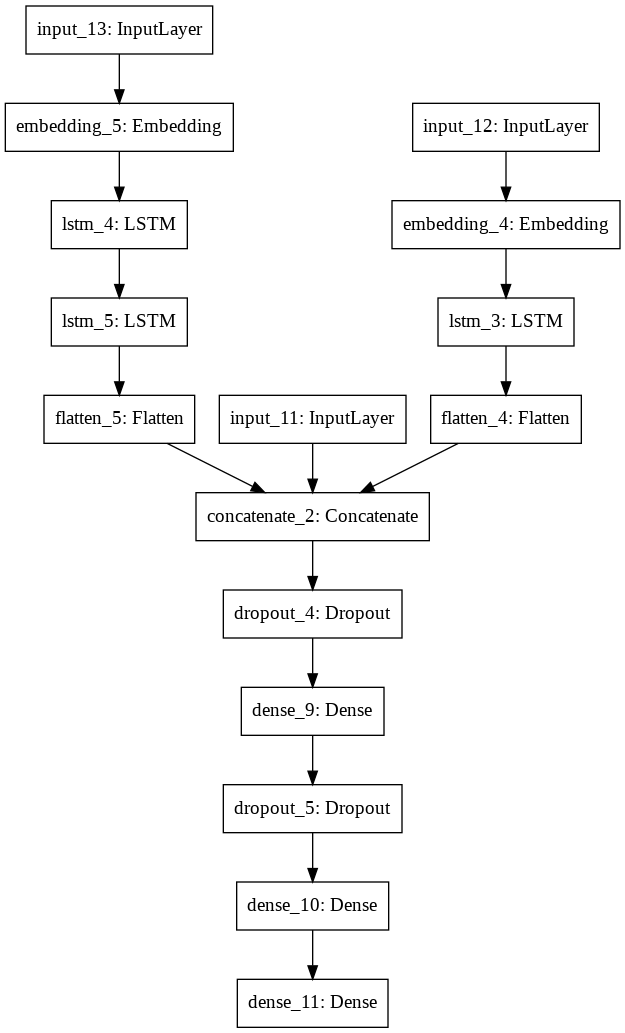

In [133]:
plot_model(model)

In [134]:
import keras.backend as K
msle = tf.keras.losses.MeanSquaredLogarithmicError()

def root_mean_squared_logarithmic_error(y_true, y_pred):
    return K.sqrt(msle(y_true, y_pred))

In [135]:
model.compile(loss = root_mean_squared_logarithmic_error, optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(), 'mean_squared_logarithmic_error', root_mean_squared_logarithmic_error])

In [136]:
history = model.fit(x=[inputA_train, inputName_train, inputDesc_train], y=y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=([inputA_validation, inputName_validation, inputDesc_validation], y_validation),
                    batch_size=512)

Epoch 1/20
2261/2261 [==============================] - 55s 22ms/step - loss: 0.7130 - mse: 1489.7029 - mae: 15.6055 - root_mean_squared_error: 38.5473 - mean_squared_logarithmic_error: 0.5915 - root_mean_squared_logarithmic_error: 0.7130 - val_loss: 0.5552 - val_mse: 1127.7937 - val_mae: 12.8965 - val_root_mean_squared_error: 33.5826 - val_mean_squared_logarithmic_error: 0.3089 - val_root_mean_squared_logarithmic_error: 0.5552
Epoch 2/20
2261/2261 [==============================] - 48s 21ms/step - loss: 0.5526 - mse: 1182.3161 - mae: 12.9984 - root_mean_squared_error: 34.3797 - mean_squared_logarithmic_error: 0.3060 - root_mean_squared_logarithmic_error: 0.5526 - val_loss: 0.5375 - val_mse: 1064.6044 - val_mae: 12.5310 - val_root_mean_squared_error: 32.6283 - val_mean_squared_logarithmic_error: 0.2895 - val_root_mean_squared_logarithmic_error: 0.5376
Epoch 3/20
2261/2261 [==============================] - 46s 21ms/step - loss: 0.5364 - mse: 1071.1223 - mae: 12.5667 - root_mean_squared

KeyboardInterrupt: ignored

In [ ]:
histDf = pd.DataFrame(history.history)
histDf.tail()

In [ ]:
histDf.plot(y=["loss", "val_loss"])